Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-alexnet-cifar10.ipynb)

## Code Modules, Classes & Functions

In [ ]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from tensorflow import image as timage
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torch.utils.data.dataset import Subset
import torch.nn as tnn
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" if torch.cuda.is_available() 
                 else "cpu")

In [ ]:
class TData(tds):
    def __init__(self,X,y):   
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        train_img,train_lbl=self.X[index],self.y[index]
        return train_img,train_lbl
    def __len__(self):
        return self.y.shape[0]

In [ ]:
class AlexNN(tnn.Module):
    def __init__(self,num_classes):
        super(AlexNN,self).__init__()
        self.features=tnn.Sequential(
            tnn.Conv2d(3,64,kernel_size=11,
                       stride=4,padding=2),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(kernel_size=3,stride=2),
            tnn.Conv2d(64,192,kernel_size=5,padding=2),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(kernel_size=3,stride=2),
            tnn.Conv2d(192,384,kernel_size=3,padding=1),
            tnn.ReLU(inplace=True),
            tnn.Conv2d(384,256,kernel_size=3,padding=1),
            tnn.ReLU(inplace=True),
            tnn.Conv2d(256,256,kernel_size=3,padding=1),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(kernel_size=3,stride=2))
        self.avgpool=tnn.AdaptiveAvgPool2d((6,6))
        self.classifier=tnn.Sequential(
            tnn.Dropout(.5),
            tnn.Linear(256*6*6,4096),
            tnn.ReLU(inplace=True),
            tnn.Dropout(.5),
            tnn.Linear(4096,4096),
            tnn.ReLU(inplace=True),
            tnn.Linear(4096,num_classes))
    def forward(self,x):
        x=self.features(x)
        x=self.avgpool(x)
        x=x.view(x.size(0),256*6*6)
        logits=self.classifier(x)
        probs=tnn.functional.softmax(logits,dim=1)
        return logits,probs

In [ ]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def display_examples(data_loader):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(64,64,3))
        break
def show_image(img):
    npimg=img.numpy()/2.+.5; tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
def show_examples(train_loader,classes,num_examples):
    dataiter=iter(train_loader)
    images,labels=dataiter.next()
    show_image(utils.make_grid(images[0:num_examples]))
    print('^'.join('%9s'%classes[labels[j]] 
                   for j in range(num_examples)),end='^')

In [ ]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%200:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader2),
                   model_acc(model,valid_loader2)))
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [ ]:
random_seed=1; batch_size=128
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5)
train_transform=transforms\
.Compose([transforms.Resize((70,70)),
          transforms.RandomCrop((64,64)),
          transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
test_transform=transforms\
.Compose([transforms.Resize((70,70)),
          transforms.CenterCrop((64,64)),
          transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',train=True,download=True,
                     transform=train_transform)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False, 
              transform=test_transform)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/cifar-10-python.tar.gz to data


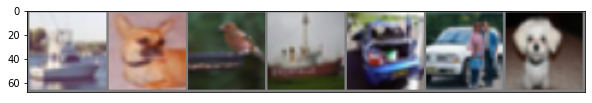


     ship^      dog^     bird^     ship^      car^      car^      dog^

In [ ]:
classes=('plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck')
show_examples(valid_loader,classes,7)

In [ ]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')/255
x=np.array(timage.resize(x,[64,64]))\
.reshape(-1,3,64,64)
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
x_valid.shape,y_valid.shape

['backgrounds', 'images', 'labels']


((1419, 3, 64, 64), (1419,))

Image dimensions: torch.Size([128, 3, 64, 64])
Label dimensions: torch.Size([128])


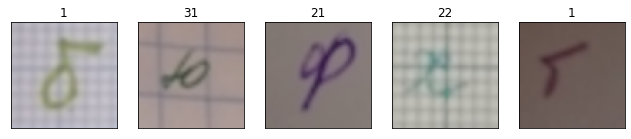

In [ ]:
random_seed=1; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,batch_size=batch_size2,shuffle=True)
valid_loader2=tdl(dataset=valid2,batch_size=batch_size2,shuffle=True)
test_loader2=tdl(dataset=test2,batch_size=batch_size2,shuffle=False)
display_examples(valid_loader2)

## AlexNet Training

In [ ]:
torch.manual_seed(random_seed)
num_classes=10; learning_rate=.0001
model=AlexNN(num_classes)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate) 

In [ ]:
%train_run 10

Epoch: 001/010 | Batch 000/343 | Cost: 2.3028
Epoch: 001/010 | Batch 300/343 | Cost: 1.6590
Epoch: 001/010 train accuracy: 36.52%
Epoch: 002/010 | Batch 000/343 | Cost: 1.6707
Epoch: 002/010 | Batch 300/343 | Cost: 1.4625
Epoch: 002/010 train accuracy: 44.53%
Epoch: 003/010 | Batch 000/343 | Cost: 1.5459
Epoch: 003/010 | Batch 300/343 | Cost: 1.4076
Epoch: 003/010 train accuracy: 50.25%
Epoch: 004/010 | Batch 000/343 | Cost: 1.3564
Epoch: 004/010 | Batch 300/343 | Cost: 1.3427
Epoch: 004/010 train accuracy: 55.99%
Epoch: 005/010 | Batch 000/343 | Cost: 1.2840
Epoch: 005/010 | Batch 300/343 | Cost: 1.1167
Epoch: 005/010 train accuracy: 57.69%
Epoch: 006/010 | Batch 000/343 | Cost: 1.2160
Epoch: 006/010 | Batch 300/343 | Cost: 1.0318
Epoch: 006/010 train accuracy: 61.76%
Epoch: 007/010 | Batch 000/343 | Cost: 0.9902
Epoch: 007/010 | Batch 300/343 | Cost: 1.1276
Epoch: 007/010 train accuracy: 61.33%
Epoch: 008/010 | Batch 000/343 | Cost: 1.0878
Epoch: 008/010 | Batch 300/343 | Cost: 1.032

In [ ]:
%print_acc 1

Train accuracy: 67.8273%
Valid accuracy: 64.2333%
Test accuracy: 64.3700%


In [ ]:
torch.manual_seed(random_seed)
num_classes=33; learning_rate=.0001
model=AlexNN(num_classes)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate) 

In [ ]:
%train_run2 30

Epoch: 001/030 | Batch 000/088 | Cost: 3.4962
Epoch: 001/030 | Batch 050/088 | Cost: 3.5012
Epoch: 001/030 train acc: 3.35% valid acc: 3.38%
Epoch: 002/030 | Batch 000/088 | Cost: 3.4613
Epoch: 002/030 | Batch 050/088 | Cost: 3.3804
Epoch: 002/030 train acc: 5.28% valid acc: 5.21%
Epoch: 003/030 | Batch 000/088 | Cost: 3.3523
Epoch: 003/030 | Batch 050/088 | Cost: 3.3838
Epoch: 003/030 train acc: 5.54% valid acc: 5.00%
Epoch: 004/030 | Batch 000/088 | Cost: 3.4077
Epoch: 004/030 | Batch 050/088 | Cost: 3.3438
Epoch: 004/030 train acc: 5.36% valid acc: 5.57%
Epoch: 005/030 | Batch 000/088 | Cost: 3.3508
Epoch: 005/030 | Batch 050/088 | Cost: 3.3882
Epoch: 005/030 train acc: 5.68% valid acc: 6.34%
Epoch: 006/030 | Batch 000/088 | Cost: 3.4046
Epoch: 006/030 | Batch 050/088 | Cost: 3.2925
Epoch: 006/030 train acc: 7.62% valid acc: 8.17%
Epoch: 007/030 | Batch 000/088 | Cost: 3.4039
Epoch: 007/030 | Batch 050/088 | Cost: 3.3408
Epoch: 007/030 train acc: 8.45% valid acc: 8.53%
Epoch: 008/03

In [ ]:
%print_acc 2

Train accuracy: 55.3207%
Valid accuracy: 48.2734%
Test accuracy: 45.7364%
